In [1]:
!pip install opencv-python


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure, filters, color
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras import losses
from keras.layers import Conv2D, Dense, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras.layers import Add, Input, ZeroPadding2D, Activation, Flatten, Dropout
from keras.models import Sequential, Model
import keras.backend as K
import tensorflow as tf
import random
from keras.applications.vgg16 import VGG16

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [6]:
'''
LOADING DATA AND PREPROCESSING
'''

def load_data(dir_data, dir_labels, training=True):
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data = []
    for identifier in ids:
        fname = dir_data + identifier.astype(str) + '.tif'
        image = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data)
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

# Define dataset directories
DIR_TRAIN_IMAGES = "/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Data/training/"
DIR_TEST_IMAGES  = "/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Data/testing/"
DIR_TRAIN_LABELS = "/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Data/labels_training.csv"
DIR_TEST_IDS     = "/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Data/sample_submission.csv"

# Load train and test data
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)
X_test, test_ids = load_data(DIR_TEST_IMAGES, DIR_TEST_IDS, training=False)

# Resize each image in X_train to (100, 100)
X = [cv2.resize(img, (100, 100)) for img in X]
X = np.array(X)

# Print data shape
print('X shape:\n', X.shape)
print('X_test shape:\n', X_test.shape)

# Check the number of samples in each class
print('Distribution of y', np.bincount(y))

# Scale pixel values between 0 and 1
X = X / 255.0
X_test = X_test / 255.0




X shape:
 (1500, 100, 100, 3)
X_test shape:
 (558, 101, 101, 3)
Distribution of y [995 505]


In [7]:
import matplotlib.pyplot as plt

def show_images(image_ids, num_images, title):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4
    plt.figure()
    n = 1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        plt.imshow(X[i, :, :, :])
        plt.title('Image id: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        n += 1

    plt.suptitle(title, fontsize=15)
    plt.show()

# You can then use this function to visualize images as shown in your code.

In [8]:


'''
MODEL 1: CONVOLUTIONAL NEURAL NETWORK (CNN)
'''

# Define CNN model
def build_model():
    IMAGE_HEIGHT = 100
    IMAGE_WIDTH = 100
    IMAGE_CHANNELS = 3

    model = Sequential()

    # Layer 1
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    model.add(BatchNormalization())

    # Layer 2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Layer 3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Max-pooling
    model.add(MaxPooling2D(pool_size=2))

    # Layer 4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Layer 5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Max-pooling
    model.add(MaxPooling2D(pool_size=2))

    # Layer 6
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Layer 7
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Global-max-pooling
    model.add(GlobalMaxPooling2D())

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Cross-validate CNN model
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    prediction_scores = np.empty(y.shape[0], dtype='object')
    prediction_class = np.empty(y.shape[0], dtype='object')
    random_seed = 1
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]
        class_weight = {0: 505/1500, 1: 995/1500}
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=40,
                           shuffle=True,
                           verbose=0)
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))
        prediction_scores[val_index] = y_val_pred_probs
    return prediction_scores

num_folds      = 3
random_seed    = 1
cnn            = build_model()
cnn.summary()
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

# Look at TP, TN, FP, and FN
df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])

cnn.save('/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Trained_Model_h5/CNN/cnn_model.h5')



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 96, 96, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 128)       73856     
                                                                 
 batch_normalization_9 (Bat  (None, 94, 94, 128)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# num_images = 7  # number of images to look at
# show_images(tp, num_images, 'Examples of True Positives')
# show_images(fp, num_images, 'Examples of False Positives')
# show_images(tn, num_images, 'Examples of True Negatives')
# show_images(fn, num_images, 'Examples of False Negatives')

In [10]:
'''
MODEL 2: VGG16
'''

def build_vgg16_model():
    base_model = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(100, 100, 3))

    # Freeze the layers
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Cross-validate VGG16 model
num_folds = 3
random_seed = 1
vgg16 = build_vgg16_model()
vgg16.summary()
vgg16_y_hat_prob = cv_performance_assessment(X, y, num_folds, vgg16, random_seed=random_seed)

# Look at TP, TN, FP, and FN
df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = [1 if pred >= 0.5 else 0 for pred in vgg16_y_hat_prob]

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])

vgg16.save('/content/drive/MyDrive/Data_Science/01_Projects/02_VGG_CNN_KNN_LR/Trained_Model_h5/VGG/vgg16_model.h5')

# num_images = 7  # number of images to look at
# show_images(tp, num_images, 'Examples of True Positives')
# show_images(fp, num_images, 'Examples of False Positives')
# show_images(tn, num_images, 'Examples of True Negatives')
# show_images(fn, num_images, 'Examples of False Negatives')

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15894849 (60.63 MB)
Trainable params: 1180161 (4.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
16/16 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np

def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment
    Input:
        X          : training data
        y          : training labels
        num_folds  : number of folds for cross-validation
        clf        : classifier to use
        random_seed: seed for random number generator

    Divide the training data into k folds of training and validation data.
    For each fold, the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and returned.

    Returns:
        prediction_scores: an array of prediction scores for each data point
        prediction_class : an array of predicted class labels (0 or 1)
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')
    prediction_class = np.empty(y.shape[0], dtype='object')

    # Establish the k folds
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the classifier
        clf.fit(X_train, y_train)

        # Test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict_proba(X_val)[:, 1]
        y_val_pred_class = clf.predict(X_val)

        # Save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs
        prediction_class[val_index] = y_val_pred_class

    return prediction_scores, prediction_class


In [13]:
# Define KNN model
# Define k, p, weight based on hyperparameter tuning or specific values
k = 5  # Example value for k (you can replace it)
p = 2  # Example value for p (you can replace it)
weight = 'uniform'  # Example weight (you can replace it)

def preprocess_and_extract_features(data):
    fd_all = []
    for row in data:
        resized_img = resize(row, (100, 100))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
                 cells_per_block=(2, 2), visualize=False, multichannel=True)
        fd_all.append(fd)
    fd_all = np.array(fd_all)
    features = fd_all

    ss = StandardScaler()
    ss.fit(features)
    features = ss.transform(features)

    return features

# Assuming you have already loaded and preprocessed your image data

# Preprocess the images and extract features
X_features = preprocess_and_extract_features(X)

# Now, you can use X_features with KNN

# Assuming you have already created and configured your KNN classifier
knn = KNeighborsClassifier(n_neighbors=k, p=p, weights=weight)
knn.fit(X_features, y)

# Cross-validate KNN model
num_folds   = 5
random_seed = 1
hog_knn_y_hat_prob, hog_knn_y_hat_class = cv_performance_assessment(X_features, y, num_folds, knn, random_seed=random_seed)

# Look at TP, TN, FP, and FN
df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = hog_knn_y_hat_prob

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])


<ipython-input-13-e9f70eb925d8>:11: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),


In [14]:
'''
MODEL 4: LOGISTIC REGRESSION
'''

from sklearn.linear_model import LogisticRegression

# Flatten each image into a 1D vector
num_samples, num_channels, image_height, image_width = X.shape
X_flattened = X.reshape((num_samples, num_channels * image_height * image_width))

# Now, you can use X_flattened with Logistic Regression

# Assuming you have already created and configured your Logistic Regression classifier
base_model = LogisticRegression(solver='lbfgs')

# Cross-validate baseline model
num_folds = 5
random_seed = 1
baseline_y_hat_prob, baseline_y_hat_class = cv_performance_assessment(
    X_flattened, y, num_folds, base_model, random_seed=random_seed)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

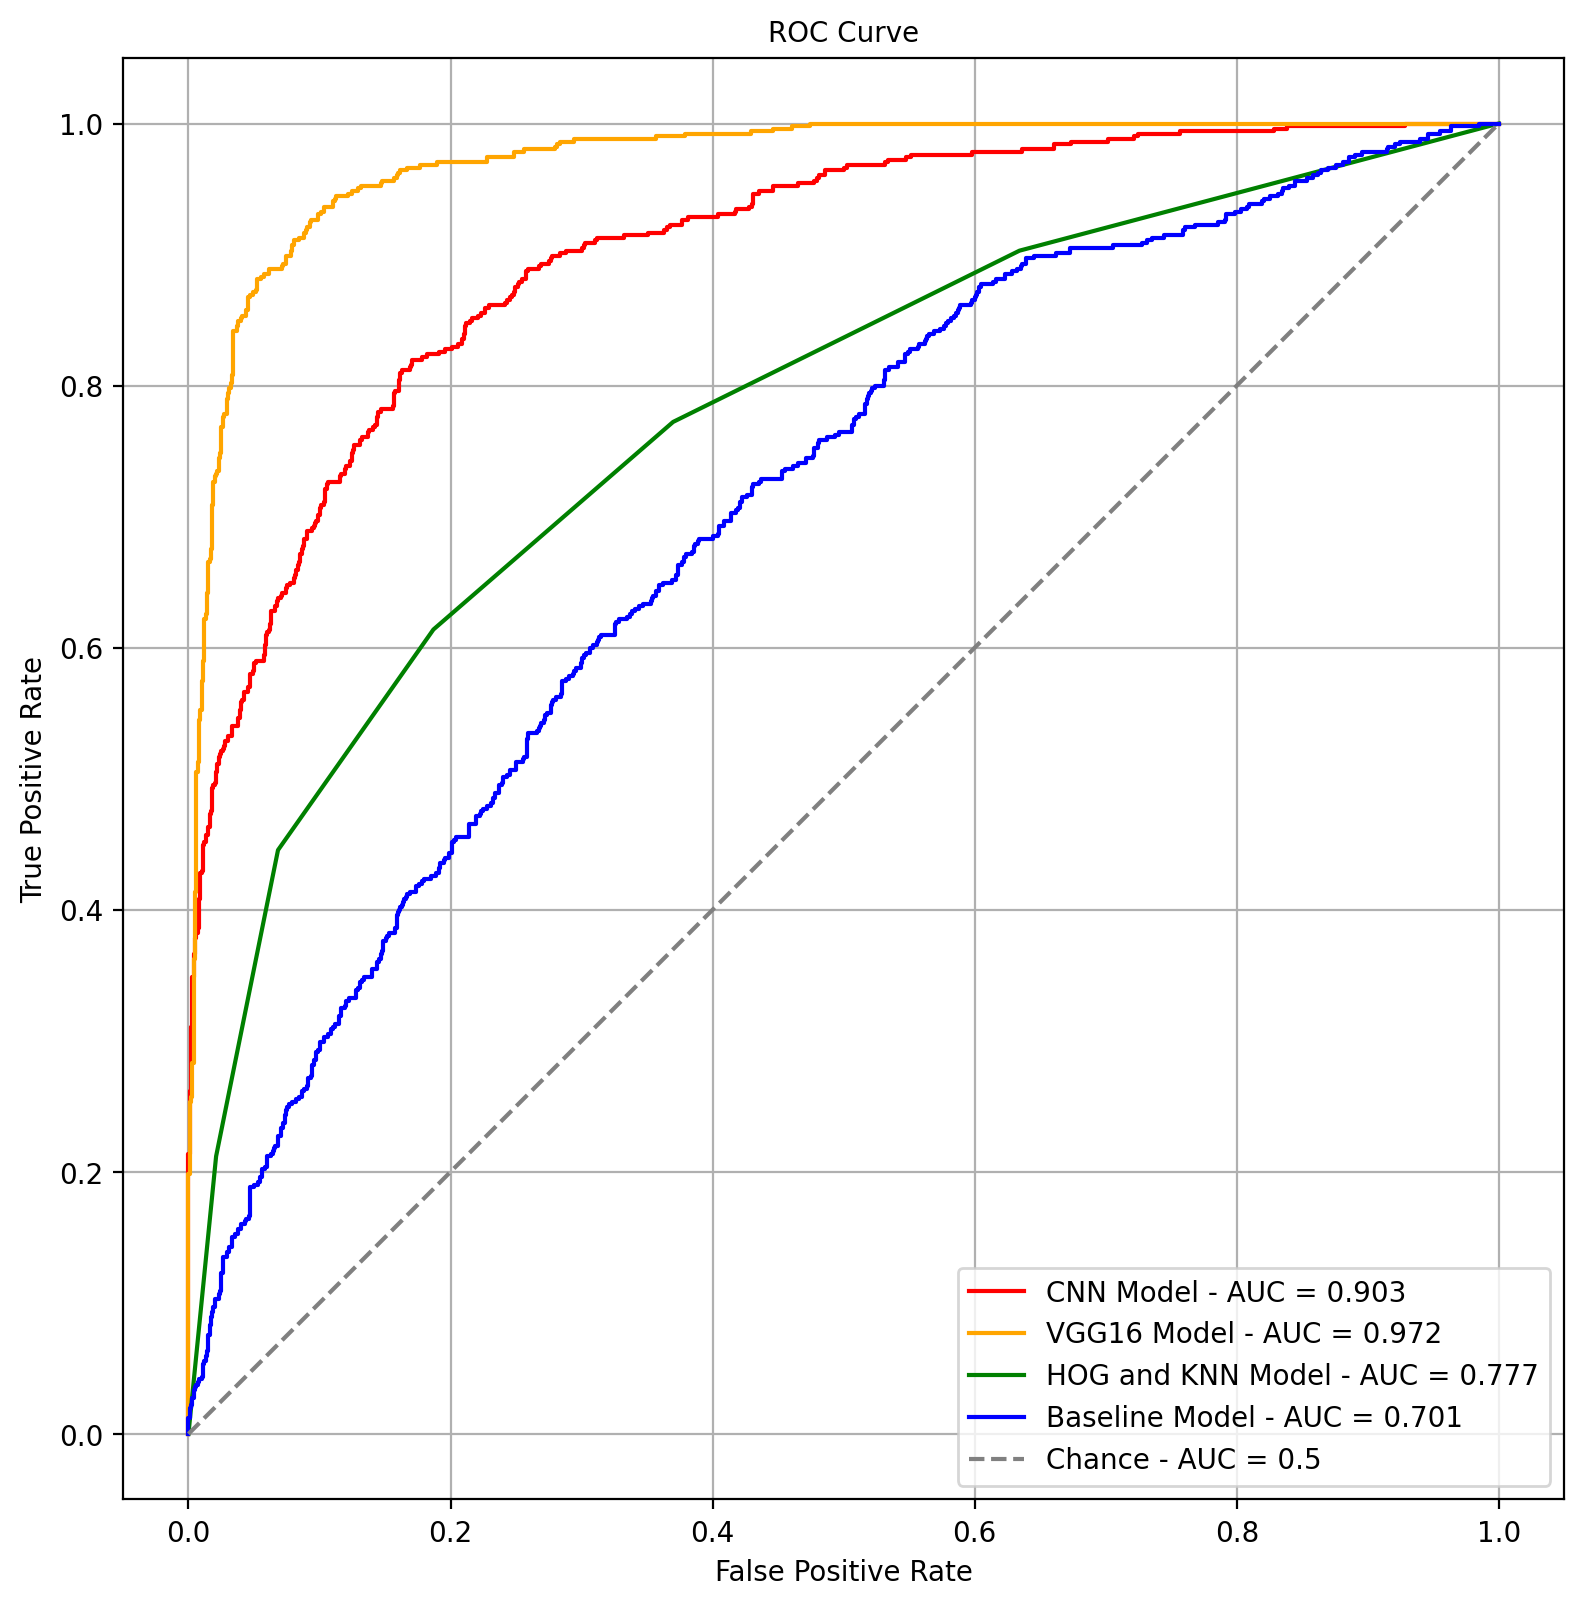

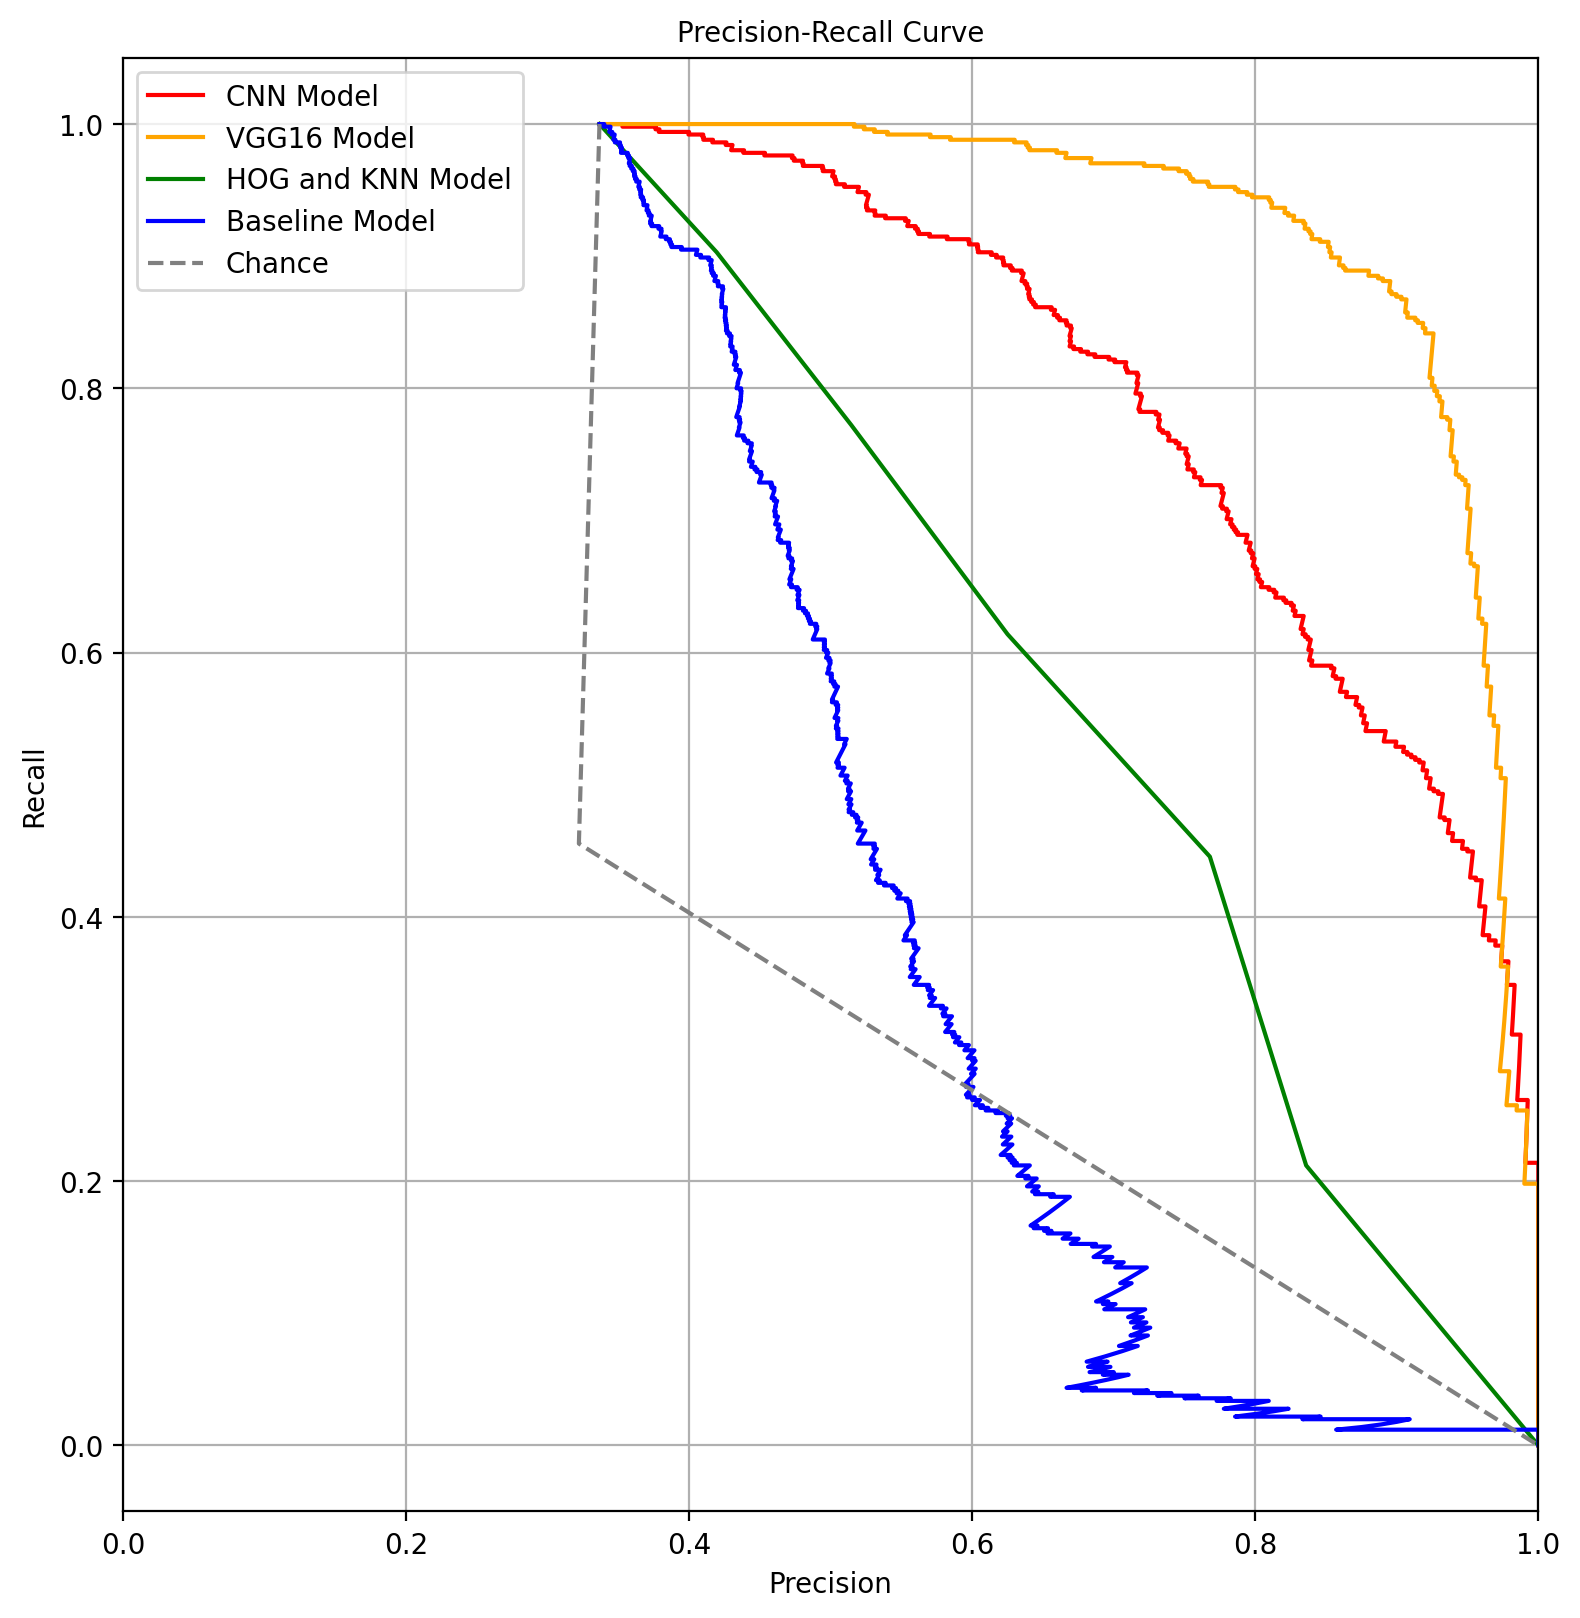

In [15]:


'''
MODEL EVALUATION
'''

# Plot ROC and PR curves for all models
def plot_roc(y_true, y_pred_baseline, y_pred_knn, y_pred_cnn, y_pred_vgg16):
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of VGG16
    fpr, tpr, _ = roc_curve(y_true, y_pred_vgg16, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_vgg16)
    legend_string = 'VGG16 Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='orange', label=legend_string)

    # ROC of KNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_knn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_knn)
    legend_string = 'HOG and KNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='green', label=legend_string)

    # ROC of baseline model
    fpr, tpr, _ = roc_curve(y_true, y_pred_baseline, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_baseline)
    legend_string = 'Baseline Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='blue', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)

def plot_pr(y_true, y_pred_baseline, y_pred_knn, y_pred_cnn, y_pred_vgg16):
    plt.figure(figsize=(8, 8))

    # PR of CNN
    precision, recall, _ = precision_recall_curve(y_true, y_pred_cnn, pos_label=1)
    legend_string = 'CNN Model'
    plt.plot(precision, recall, color='red', label=legend_string)

    # PR of VGG16
    precision, recall, _ = precision_recall_curve(y_true, y_pred_vgg16, pos_label=1)
    legend_string = 'VGG16 Model'
    plt.plot(precision, recall, color='orange', label=legend_string)

    # PR of KNN
    precision, recall, _ = precision_recall_curve(y_true, y_pred_knn, pos_label=1)
    legend_string = 'HOG and KNN Model'
    plt.plot(precision, recall, color='green', label=legend_string)

    # PR of baseline model
    precision, recall, _ = precision_recall_curve(y_true, y_pred_baseline, pos_label=1)
    legend_string = 'Baseline Model'
    plt.plot(precision, recall, color='blue', label=legend_string)

    # PR of chance
    p_r = np.random.randint(2, size=len(y_true))
    precision_r, recall_r, _ = precision_recall_curve(y_true, p_r, pos_label=1)
    legend_string_r = 'Chance'
    plt.plot(precision_r, recall_r, '--', color='gray', label=legend_string_r)

    plt.xlim([0, 1])
    plt.legend()
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid('on')
    plt.tight_layout()
    plt.title('Precision-Recall Curve', fontsize=10)

# Plot ROC and PR curves
plot_roc(y, baseline_y_hat_prob, hog_knn_y_hat_prob, cnn_y_hat_prob, vgg16_y_hat_prob)
plot_pr(y, baseline_y_hat_prob, hog_knn_y_hat_prob, cnn_y_hat_prob, vgg16_y_hat_prob)
plt.show()
